
ERT modeling and inversion in 2D
================================



This code uses the open-source library: <br/> pyGIMLi (www.pygimli.org) and PyBERT (https://pypi.org/project/PyBERT/) to create mesh, perform forward modeling and run the inversion. 

A number of python libraries such as matplotlib, numpy, pandas are also used. The file geo05.yml is a list of describing python environment where all necessary libraries are installed. The yml file can be used to re-create the proper environment with conda. Note that geo05 uses "jupyter lab", not "jupyer notebook"

**To run, this code requires the companion file:**<br>
Init_ERT2D.py

## Initialisation cells

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from Init_ERT2D_3_5 import *

## Read the data file from TIGRE
You need to edit the name of input file here to match your input data file.<br>
That would be the file uploaded in the same folder as this code, and it will be either the **res** or **dat** file from the tigre array. 

In [2]:
#example file 1:
input_file='./FlassVale01_interp.dat'

#example file 2:
#input_file='./c1_1m.res'

dx,Nread,Nel,elpos,readings = read_dat(input_file)

,0
0,Harry flass vale bower: Line 1 / Spread 1
1,0.25
2,1
3,650
4,1
5,0


tot readings:  650.0 || el. spacing dx=  0.25 || nr. of electrodes  Nel =  63


## Input topography vector with n=Nel values.
If you known the topography (relative elevation for each electrode) you should input it here using
<code>   
topography = [z_1, z_2, .... z_Nel] 
</code>
where 1, 2, ... Nel is are the electrodes and z is their elevation.
If topography is negligible just use
<code>
topography = np.zeros(Nel)
</code>
make sure the topography vector has the same number of values as the number of electrodes. 

In [3]:
# case with known topography for "FlassVale01_interp.dat" example (63 electrodes):
topography=[70.2083781 , 70.25612936, 70.29714876, 70.33390108, 70.37253795,
       70.42013276, 70.48375885, 70.56810439, 70.66831675, 70.77715812,
       70.88739067, 70.99401378, 71.10097568, 71.21446183, 71.34065765,
       71.48262625, 71.63094135, 71.77305433, 71.89641657, 71.99142024,
       72.06022059, 72.1079137 , 72.1395956 , 72.16003001, 72.17265119,
       72.18056108, 72.18686159, 72.19424756, 72.20378544, 72.2161346 ,
       72.23195441, 72.2507575 , 72.26746962, 72.2758698 , 72.26973708,
       72.24455895, 72.20265694, 72.14806104, 72.08480125, 72.01659512,
       71.9459104 , 71.87490236, 71.80572631, 71.73903095, 71.66943862,
       71.59006507, 71.49402606, 71.37944692, 71.2644913 , 71.17233244,
       71.12614357, 71.13826896, 71.17773707, 71.2027474 , 71.17149943,
       71.05677538, 70.88968824, 70.71593373, 70.58120754, 70.51859371,
       70.51072949, 70.52764048, 70.53935227]
len(topography),Nel

(63, 63)

## Validate and check topography 

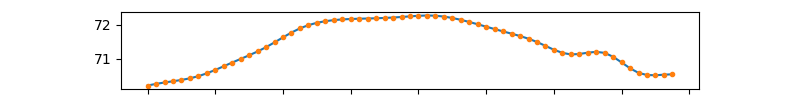

In [4]:
elpos=make_topo(topography,elpos,Nel,dx)
fig,ax=plt.subplots(figsize=(8,1))
ax.plot(elpos[:,0],elpos[:,2]);ax.plot(elpos[:,0],elpos[:,2],'.');ax.set_aspect('equal')

## Give error, re-format data and save to new file. 
The estimate of average error will be used in case some or all of the original data has no error

In [5]:
# Give average error estmate (usually 2 or 3 %):
err_avg=0.03 

# Organise resistivity and corresponding electrode indexes, PYBERT-unified style, in array abmnr:
abmnr=make_abmnr(input_file,readings,dx,err_avg)

# Write formatted uni2 file:
filout=write_formatted(err_avg,input_file,Nel,elpos,Nread,abmnr)
print('Formatted data saved in file:\n',filout)

Formatted data saved in file:
 ./FlassVale01_interp_uni2.csv


# Run inversion to estimate the model.

In the next cell, the formatted data is imported,  the manager is set up and the inversion is performed <br>
A mesh is created on-the-fly based on the sensor positions <br>
The `invert` function returns the model estimate. A number of options can be modified as needed:

### OPTIONAL PARAMETERS AND SOME INDICATIVE VALUES:
<code>
 maxIter=12             | Will stop after maxIter cycles if not converged yet 
 quality = 28           | Quality of the mesh. lower if code crashes.
 useGradient=True       | Inital model has a vertical velocity gradient or not
 vTop=150, vBottom=3000 | Initial model gradient is imposed by setting top and bottom velocities.
                          Usually leave these out by commenting them with #
 limits=[150,3000]      | Limits to max and min possible velocities in model.
                          Use max min estimates from linear fit of arrival times.
 paraMaxCellSize=10     | Limit the size of the cells in the mesh. Small look nicer but slower. 
                          Increase if code crashes. Start testing with large values. 
                          When happy with result, reduce to approximate geophone spacing. 
 paraDepth=50           | Likely penetration depth of the survey, plus some
 zWeight=0.1            | 0-1, smaller value will perfer layered solution. 
 lam= 50                | Regularisation parameter, will prefer smoother (reduced curvature) solutions if large
                          Large lam will also converge faster.
 cType=1                | Set the type of mninimisation process, should not make a big difference
 verbose=1              | Printout a lot of info if set to 1
</code>

In [6]:
mgr = ert.ERTManager()
data = mgr.load(filout)
data['k'] = ert.createGeometricFactors(data, numerical=True)
model = mgr.invert(data, maxIter=12, quality = 30,
          useGradient=False, #vTop=150, vBottom=300, 
          #limits=[100,3800],
          paraMaxCellSize=0.125, paraDepth=4,
          zWeight=0.2, lam= 150, cType=1, 
          verbose=1)
#

./core/src/bert/bertDataContainer.cpp:107		virtual void GIMLI::DataContainerERT::checkDataValidityLocal()  In datafile zero current or voltage found.
26/05/24 - 13:35:03 - pyGIMLi - INFO - Cache /home/stefan/anaconda3/envs/geo05/lib/python3.11/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (12.5s x 4): /home/stefan/.cache/pygimli/18204754027079216845
26/05/24 - 13:35:03 - pyGIMLi - INFO - Found 2 regions.
26/05/24 - 13:35:03 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
26/05/24 - 13:35:03 - pyGIMLi - INFO - Found 2 regions.
26/05/24 - 13:35:03 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
26/05/24 - 13:35:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
26/05/24 - 13:35:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
26/05/24 - 13:35:03 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3787 Cells: 7256 Boundaries: 5600


Data validity check: found 22 invalid data. 
Data validity check: remove invalid data.


26/05/24 - 13:35:03 - pyGIMLi - INFO - Use median(data values)=860.5563500000001
26/05/24 - 13:35:03 - pyGIMLi - INFO - Created startmodel from forward operator: 1444, min/max=860.556350/860.556350
26/05/24 - 13:35:03 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  3

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  4

Statistics:

  Input vertices: 133
  Input segments: 134
  Input holes: 0

  Mesh vertices: 987
  Mesh triangles: 1814
  Mesh edges: 2800
  Mesh exterior boundary edges: 158
  Mesh interior boundary edges: 49
  Mesh subsegments (constrained edges): 207

min/max(dweight) = 33.3333/33.3333
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f0be70cf1a0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f0bdef2aed0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7f0bdef595b0>

## Plot the result

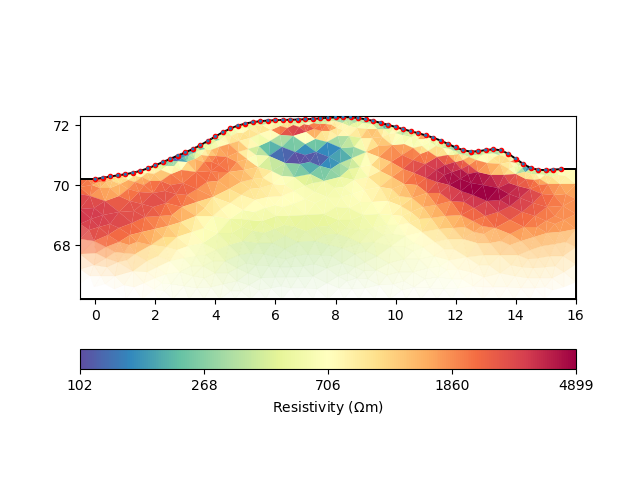

In [9]:
mgr.showResult()#(coverage=ert.coverage())
fig2=plt.gcf()
ax2 = fig2.axes[0]
ax2.plot(elpos[:,0],elpos[:,2],'ro',ms=3);
#fig.axes[0].set(ylim=(-45.0, 0.0))
#fig.set_size_inches(6,3);

Detecting small distances, using mm accuracy


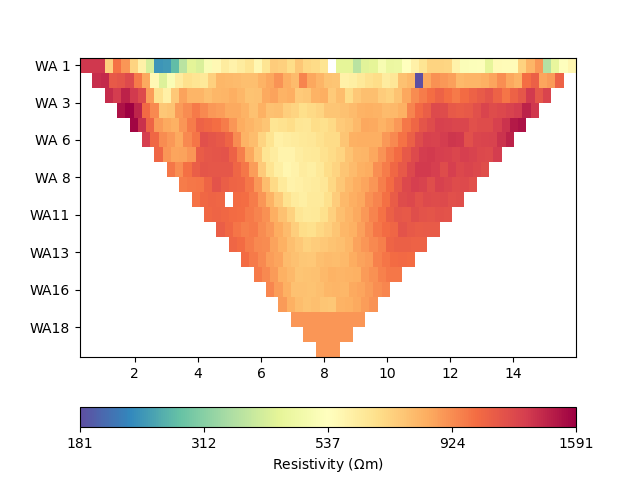

In [11]:
mgr.showData();